<a href="https://colab.research.google.com/github/irwardhana/DEVSAT_ENV/blob/main/network_fault_pipeline_Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== MEMUAT DATA ===
Membuat Label dari Ticket Data...
Distribusi Label:
label
0    33281
1     1471
Name: count, dtype: int64
Menerapkan SMOTE...

=== TRAINING MODEL ===
Training Random Forest...
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:32:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== PERBANDINGAN PERFORMA ===
           Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0  Random Forest    0.9875     0.7836  0.9728     0.868   0.9951
1        XGBoost    0.9875     0.7836  0.9728     0.868   0.9958


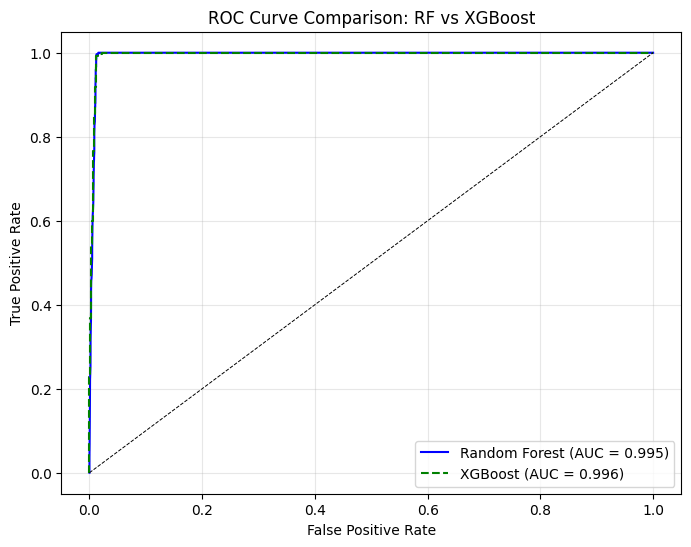

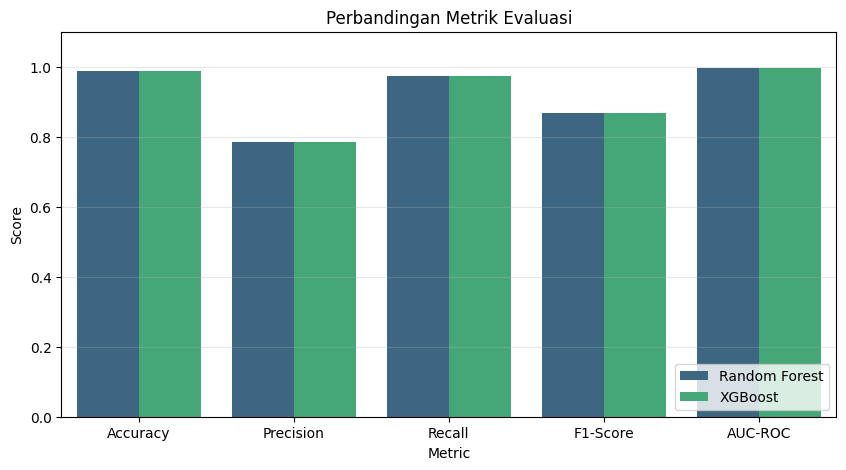

In [3]:
# ============================================================
# 1. SETUP & DATA LOADING
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb  # Library XGBoost

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, roc_auc_score,
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

print("=== MEMUAT DATA ===")
# Load dataset
snmp_df = pd.read_csv('SNMP_Data.csv')
syslog_df = pd.read_csv('Syslog_Data.csv')
ticket_df = pd.read_csv('Ticket_Data.csv')

# Convert timestamps to datetime
snmp_df['timestamp'] = pd.to_datetime(snmp_df['timestamp'])
syslog_df['timestamp'] = pd.to_datetime(syslog_df['timestamp'])
ticket_df['start_time'] = pd.to_datetime(ticket_df['start_time'])
ticket_df['end_time'] = pd.to_datetime(ticket_df['end_time'])

# ============================================================
# 2. DATA MERGING & FEATURE ENGINEERING
# ============================================================

# Merge SNMP and Syslog
df = pd.merge(snmp_df, syslog_df, on=['timestamp', 'device_id'], how='left', suffixes=('_snmp', '_syslog'))

# Fill NaN
df['error_count_last_5min'] = df['error_count_last_5min'].fillna(0)
df['critical_event_flag'] = df['critical_event_flag'].fillna(0)
df['log_level'] = df['log_level'].fillna('INFO')

# Encode 'log_level'
log_mapping = {'INFO': 0, 'WARN': 1, 'ERROR': 2}
df['log_level_encoded'] = df['log_level'].map(log_mapping).fillna(0)

# Drop/Rename columns
df.rename(columns={'status_snmp': 'snmp_alert_flag', 'status_syslog': 'syslog_alert_flag'}, inplace=True)
df.drop(columns=['message', 'log_level'], inplace=True)

# ============================================================
# 3. LABEL GENERATION
# ============================================================

print("Membuat Label dari Ticket Data...")
df['label'] = 0
for _, ticket in ticket_df.iterrows():
    mask = (
        (df['device_id'] == ticket['device_id']) &
        (df['timestamp'] >= ticket['start_time']) &
        (df['timestamp'] <= ticket['end_time'])
    )
    df.loc[mask, 'label'] = 1

print(f"Distribusi Label:\n{df['label'].value_counts()}")

# ============================================================
# 4. PREPROCESSING & SPLITTING
# ============================================================

features = [col for col in df.columns if col not in ['timestamp', 'device_id', 'label']]
X = df[features].fillna(0)
y = df['label']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE (Penyeimbang Data)
print("Menerapkan SMOTE...")
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

# ============================================================
# 5. TRAINING MODEL (RF vs XGBOOST)
# ============================================================

print("\n=== TRAINING MODEL ===")

# --- Model 1: Random Forest ---
print("Training Random Forest...")
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# --- Model 2: XGBoost ---
print("Training XGBoost...")
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

# ============================================================
# 6. EVALUASI & PERBANDINGAN
# ============================================================

print("\n=== PERBANDINGAN PERFORMA ===")

# Buat DataFrame Perbandingan
metrics_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_score(y_test, y_pred_rf), accuracy_score(y_test, y_pred_xgb)],
    'Precision': [precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_xgb)],
    'Recall': [recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_xgb)],
    'F1-Score': [f1_score(y_test, y_pred_rf), f1_score(y_test, y_pred_xgb)],
    'AUC-ROC': [roc_auc_score(y_test, y_prob_rf), roc_auc_score(y_test, y_prob_xgb)]
}

comparison_df = pd.DataFrame(metrics_data)
print(comparison_df.round(4))

# --- Visualisasi Perbandingan ROC Curve ---
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {metrics_data["AUC-ROC"][0]:.3f})', color='blue')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {metrics_data["AUC-ROC"][1]:.3f})', color='green', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', lw=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: RF vs XGBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# --- Visualisasi Bar Chart Metric ---
metrics_melted = comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(10, 5))
sns.barplot(data=metrics_melted, x="Metric", y="Score", hue="Model", palette="viridis")
plt.title("Perbandingan Metrik Evaluasi")
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.grid(axis='y', alpha=0.3)
plt.show()